# Esfuerzos verticales totales y efectivos en un perfil de suelo estratificado

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

Este notebook puede ejecutarse en línea →  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/stress_vs_depth.ipynb)



## Required modules and global setup for plots

In [1]:
import ast # helps with converting str representation of python data structures
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    # run('pip install ipympl', shell=True);
    from google.colab import output
    output.enable_custom_widget_manager()

# %matplotlib widget
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "cmr", "cmr10", "DejaVu Serif"],  # or 
    "mathtext.fontset": "cm",  # Use Computer Modern fonts for math
    "axes.formatter.use_mathtext": True,  # Use mathtext for axis labels
    "axes.unicode_minus": False,   # Use standard minus sign instead of a unicode character
})

## Functions

In [2]:
def plot_stress_vs_depth(depths, 𝛾_moist, 𝛾_sat, wt_depth, 𝛾_w):
    if type(depths) == str:  # This is for interpreting in from the widget
        depths = ast.literal_eval(f"[{depths}]")
    if type(𝛾_moist) == str:  # This is for interpreting in from the widget
        𝛾_moist = ast.literal_eval(f"[{𝛾_moist}]")
    if type(𝛾_sat) == str:  # This is for interpreting in from the widget
        𝛾_sat = ast.literal_eval(f"[{𝛾_sat}]")
    # Find the index where the new value should be inserted
    min_idx = min(len(depths), len(𝛾_moist), len(𝛾_sat))
    depths_copy = depths[:min_idx].copy()
    𝛾_moist_copy = 𝛾_moist[:min_idx].copy()
    𝛾_sat_copy = 𝛾_sat[:min_idx].copy()
    # Find an appropiate index for locating the watertable
    if wt_depth >= depths[-1] or wt_depth is None:
        wt_depth = depths[-1]
        idx_wt = len(depths) - 1
    else:
        for i in range(len(depths)):
            if wt_depth <= depths[i]:
                idx_wt = i
                break
    # Insert the new value at the appropriate index
    depths_copy.insert(idx_wt, wt_depth)
    𝛾_moist_copy.insert(idx_wt, 𝛾_moist[idx_wt])
    𝛾_sat_copy.insert(idx_wt, 𝛾_sat[idx_wt])
    # Create an unified unit weight vector
    𝛾_s = 𝛾_moist_copy[: idx_wt + 1] + 𝛾_sat_copy[idx_wt + 1 :]
    # Create vector of thicknesses
    depths_copy.insert(0, 0)  # insert zero for the first layer
    thickness = np.diff(depths_copy)  # thickness of each soil layer [m]
    # Create a vector for unit weigth of water (zero above wt, and 𝛾_w below)
    𝛾_w = np.full_like(𝛾_s, 𝛾_w)
    𝛾_w[: idx_wt + 1] = 0
    # Compute vertical stressess and water pressure at boundaries
    sigma_v = np.insert(np.cumsum(thickness * 𝛾_s), 0, 0)
    p_w = np.insert(np.cumsum(thickness * 𝛾_w), 0, 0)
    sigma_v_eff = sigma_v - p_w
    # print(sigma_v, p_w, sigma_v_eff, sep="\n")

    # Plot
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[4, 4], layout="constrained")
    for d in depths:
        ax.axhline(d, color="orange", ls="--")
    ax.plot(sigma_v, depths_copy, color="r", label="$\sigma_\mathrm{v}$")
    ax.plot(
        sigma_v_eff,
        depths_copy,
        ls="--",
        lw=1.2,
        color="k",
        label="$\sigma'_\mathrm{v}$",
    )
    ax.plot(
        p_w, depths_copy, ls="--", lw=1.2, color="b", label="$p_\mathrm{w}$"
    )
    ax.axhline(
        y=wt_depth, ls="-", color="dodgerblue", lw=1.2, label="Water\ntable"
    )
    ax.axhline(0, color="orange", ls="--", label="Layer\nboundary")
    # Plot setup
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    ax.invert_yaxis()
    ax.set(
        xlabel="$\sigma_\mathrm{v}$ -- $\sigma_\mathrm{v}'$ -- $p_\mathrm{w}$",
        ylabel="Depth, $z$",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.spines[["left", "top"]].set_linewidth(1.5)
    ax.tick_params(width=1.5)
    ax.grid(True, which="major", color="gray", linestyle="--")
    plt.show()
    return


## Non-stratified profile

In [3]:
s, l = {'description_width': '50px'}, wgt.Layout(width='400px')
controls = {
    'depths': wgt.Text(value="10", description="z: ", style=s, layout=l),
    'γ_moist': wgt.Text(value="17", description="𝛾_moist: ", style=s, layout=l),
    'γ_sat': wgt.Text(value="21", description="𝛾_sat: ", style=s, layout=l),
    'wt_depth': wgt.FloatSlider(value=3, min=0, max=30, step=0.1, description='z_w', style=s, layout=l),
    'γ_w': wgt.BoundedFloatText(value=9.81, min=0, max=30, step=0.1, description='𝛾_w', style=s, layout=l),
}
fig = wgt.interactive_output(plot_stress_vs_depth, controls)
wgt.HBox((wgt.VBox(list(controls.values())), fig), layout=wgt.Layout(align_items='center'))


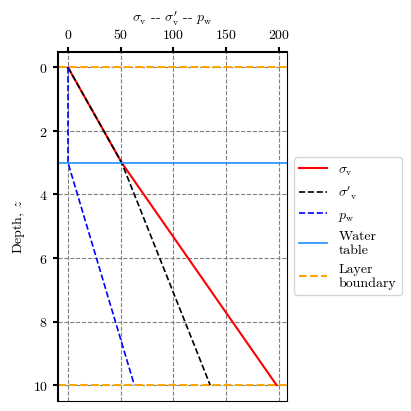

In [4]:
# Static figure
𝛾_moist = [17]  # Total/moist/bulk unit weight of each soil layer [kN/m³]
𝛾_sat = [21]  # Saturated unit weight of each soil layer [kN/m³]
depths = [10]  # bottom depth of each soil layer [m]
wt_depth = 3  # depth of the water table [m]
𝛾_w = 9.81  # unit weight of water [kN/m³]
plot_stress_vs_depth(depths, 𝛾_moist, 𝛾_sat, wt_depth, 𝛾_w)


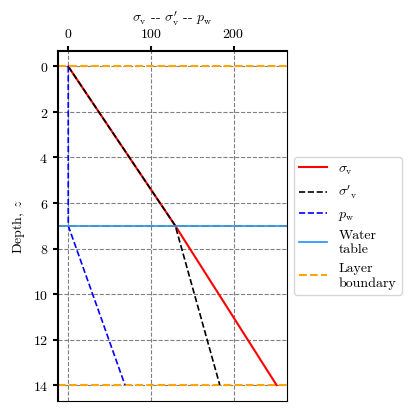

In [5]:
# Static figure
depths = [7, 14]  # bottom depth of each soil layer [m]
𝛾_moist = [18.50, 16.00]  # Total/moist/bulk unit weight of each soil layer [kN/m³]
𝛾_sat = [19.50, 17.5]  # Saturated unit weight of each soil layer [kN/m³]
wt_depth = 7  # depth of the water table [m]
𝛾_w = 9.81  # unit weight of water [kN/m³]
plot_stress_vs_depth(depths, 𝛾_moist, 𝛾_sat, wt_depth, 𝛾_w)


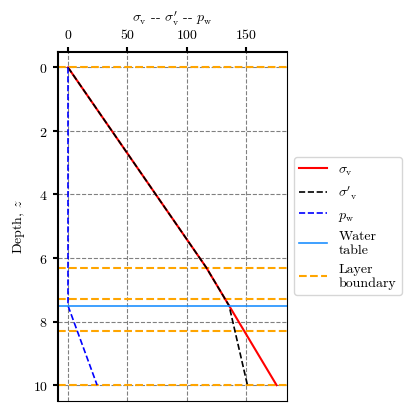

In [6]:
# Static figure
depths = [6.3, 7.3, 8.3, 10]  # bottom depth of each soil layer [m]
𝛾_moist = [18.50, 16.00, 16.00, 16.00]  # Total/moist/bulk unit weight of each soil layer [kN/m³]
𝛾_sat = [18.50, 16.00, 16.00, 16.00]  # Saturated unit weight of each soil layer [kN/m³]
wt_depth = 7.5  # depth of the water table [m]
𝛾_w = 9.81  # unit weight of water [kN/m³]
plot_stress_vs_depth(depths, 𝛾_moist, 𝛾_sat, wt_depth, 𝛾_w)


## Stratified profile

In [7]:
s, l = {'description_width': '50px'}, wgt.Layout(width='400px')
controls = {
    'depths': wgt.Text(value="5, 10, 12, 15, 20", description="z: ", style=s, layout=l),
    'γ_moist': wgt.Text(value="15, 21, 17, 20, 24", description="𝛾_moist: ", style=s, layout=l),
    'γ_sat': wgt.Text(value="16, 22, 18, 21, 25", description="𝛾_sat: ", style=s, layout=l),
    'wt_depth': wgt.FloatSlider(value=3, min=0, max=30, step=0.1, description='z_w', style=s, layout=l),
    'γ_w': wgt.BoundedFloatText(value=9.81, min=0, max=30, step=0.1, description='𝛾_w', style=s, layout=l),
    'widget': wgt.Checkbox(value=True, description='Non-vector image (improve widget performance)', disabled=False, style=s, layout=l)
}
fig = wgt.interactive_output(plot_stress_vs_depth, controls)
wgt.HBox((wgt.VBox(list(controls.values())), fig), layout=wgt.Layout(align_items='center'))
